In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, Aer, transpile, IBMQ, execute, schedule
from qiskit.test.mock.backends.toronto.fake_toronto import FakeToronto
from qiskit.test.mock.backends.rome.fake_rome import FakeRome

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-sherbrooke')

In [3]:
qasm_sim = provider.get_backend('ibmq_qasm_simulator')
sydney = provider.get_backend('ibmq_sydney')

In [4]:
syd_conf = sydney.configuration()
syd_prop = sydney.properties()

In [5]:
# Find highest single-qubit gate error rate
highest = 0
qubit = None
for q in range(syd_conf.num_qubits):
    current = syd_prop.gate_error('sx', q)
    if highest < current:
        qubit = q
        highest = current
print(f'Highest single-qubit gate error rate: qubit {qubit}')

Highest single-qubit gate error rate: qubit 12


## One quibit circuit

In [9]:
def x_measure():
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.measure_all()
    qc.h(0)
    return qc
xmeas = x_measure()
xmeas_native = transpile(xmeas, sydney, initial_layout=[qubit])
xmeas_sched = schedule(xmeas_native, sydney)
print(f'Duration of the mid-circuit X-measurement: {xmeas_sched.duration}')

Duration of the mid-circuit X-measurement: 24400


In [11]:
slots = 10
circuits = []

qc = QuantumCircuit(1,1)
qc.h(0)

for i in range(slots):
    qc = QuantumCircuit(1,1)
    qc.h(0)
    qc = transpile(qc, sydney, initial_layout=[qubit])
    
    for _ in range(i):
        qc = qc.compose(xmeas_native)
    qc.delay((slots-i-1) * xmeas_sched.duration, qarg=qubit)
    qc.measure(qubit,0)
    circuits.append(qc)

In [17]:
job = execute(circuits, qasm_sim, backend_properties=syd_prop, optimization_level=0, shots=4096) #, initial_layout=[qubit]
job.job_id()

'605b5d8a8fa7f7a02841443a'

In [25]:
res = provider.backends.retrieve_job('605b5d8a8fa7f7a02841443a').result()

In [22]:
sim_ratio = [c['1']/c['0'] for c in res.get_counts()]
sim_ratio

[0.9835351089588378,
 1.0327543424317618,
 1.0655572365103378,
 0.9616858237547893,
 0.9730250481695568,
 1.0088278567925453,
 1.0531328320802005,
 0.9701779701779701,
 1.0098135426889108,
 1.0317460317460319]

In [19]:
job = execute(circuits, sydney, shots=4096, optimization_level=0)
job.job_id()

'605b5dd46b0b890f14adb373'

In [26]:
res = provider.backends.retrieve_job('605b5dd46b0b890f14adb373').result()

In [24]:
syd_ratio = [c['1']/c['0'] for c in res.get_counts()]
syd_ratio

[0.45557924662402277,
 0.48405797101449277,
 0.553280242700038,
 0.6094302554027505,
 0.6456408196062676,
 0.6582995951417004,
 0.7459505541346974,
 0.7693304535637149,
 0.8326621923937361,
 0.9357277882797732]

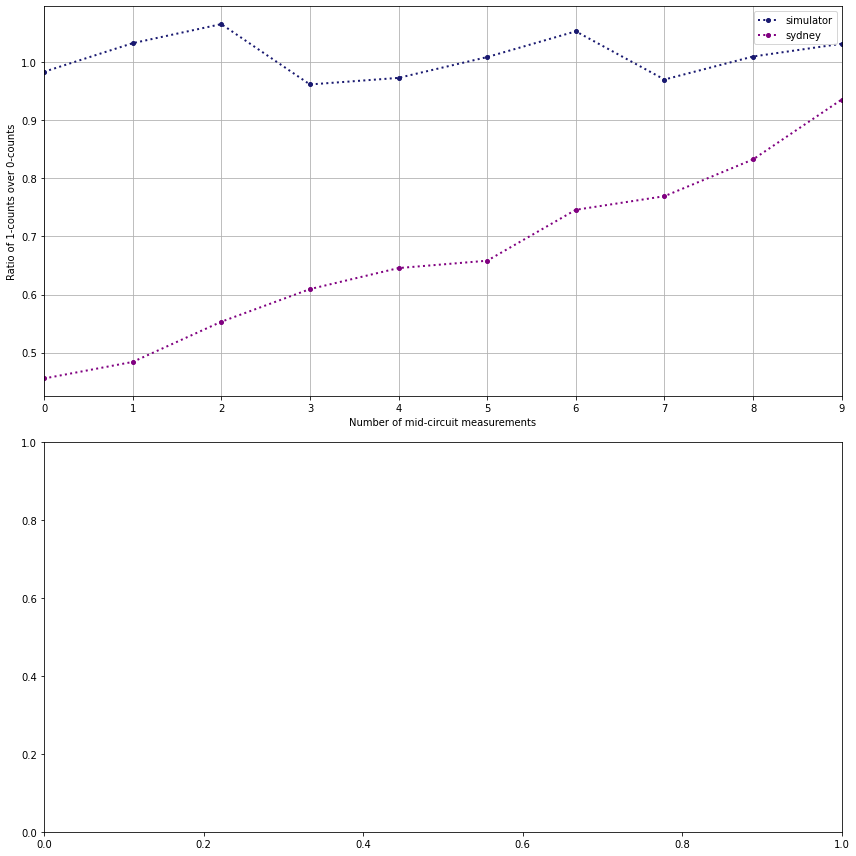

In [33]:


fig, axs = plt.subplots(2, figsize=(12,12))

axs[0].plot(list(range(slots)), sim_ratio, label='simulator', color='midnightblue', marker='o', linestyle='dotted', linewidth=2, markersize=4)
axs[0].plot(list(range(slots)), syd_ratio, label='sydney', color='purple', marker='o', linestyle='dotted', linewidth=2, markersize=4)
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel('Number of mid-circuit measurements')
axs[0].set_ylabel('Ratio of 1-counts over 0-counts')
axs[0].set_xlim(0, 9)

fig.tight_layout()
plt.show()